# Image Augmentation Notebook

This notebook generates augmented images from `data/raw/` and saves them into `data/augmented/`.

**Augmentations applied (7 images per original):**

- `_orig` - Original copy
- `_flip` - Horizontal flip
- `_br_p1` - Brightness +1 (slight increase)
- `_br_p2` - Brightness +2 (more increase)
- `_br_m1` - Brightness -1 (slight decrease)
- `_br_m2` - Brightness -2 (more decrease)
- `_noise` - Gaussian noise added


In [1]:
import os
import shutil
from pathlib import Path
import cv2
import numpy as np
from typing import Tuple

In [2]:
# Configuration
RAW_DIR = Path("data/raw")
AUGMENTED_DIR = Path("data/augmented")

# Supported image extensions
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp", ".tiff"}

# Augmentation parameters
BRIGHTNESS_P1 = 30  # Brightness increase level 1 (pixel value)
BRIGHTNESS_P2 = 60  # Brightness increase level 2 (pixel value)
BRIGHTNESS_M1 = -30  # Brightness decrease level 1 (pixel value)
BRIGHTNESS_M2 = -60  # Brightness decrease level 2 (pixel value)

NOISE_MEAN = 0  # Gaussian noise mean
NOISE_STD = 25  # Gaussian noise standard deviation

print(f"Raw directory: {RAW_DIR.absolute()}")
print(f"Augmented directory: {AUGMENTED_DIR.absolute()}")
print(f"Raw exists: {RAW_DIR.exists()}")

Raw directory: c:\Users\thatt\Documents\Coding Project\AI Project\KB-Mai-AI\model\data\raw
Augmented directory: c:\Users\thatt\Documents\Coding Project\AI Project\KB-Mai-AI\model\data\augmented
Raw exists: True


## Augmentation Functions


In [3]:
def adjust_brightness(image: np.ndarray, value: int) -> np.ndarray:
    """
    Adjust brightness of an image by adding a value to all pixels.

    Args:
        image: Input image (BGR format)
        value: Brightness adjustment value (positive = brighter, negative = darker)

    Returns:
        Brightness-adjusted image
    """
    # Convert to float to avoid overflow/underflow
    img_float = image.astype(np.float32)
    img_float += value

    # Clip values to valid range [0, 255]
    img_float = np.clip(img_float, 0, 255)

    return img_float.astype(np.uint8)

In [4]:
def horizontal_flip(image: np.ndarray) -> np.ndarray:
    """
    Flip image horizontally (left-right).

    Args:
        image: Input image

    Returns:
        Horizontally flipped image
    """
    return cv2.flip(image, 1)  # 1 = horizontal flip

In [5]:
def add_gaussian_noise(
    image: np.ndarray, mean: float = 0, std: float = 25
) -> np.ndarray:
    """
    Add Gaussian noise to an image.

    Args:
        image: Input image
        mean: Mean of the Gaussian noise
        std: Standard deviation of the Gaussian noise

    Returns:
        Noisy image
    """
    # Generate Gaussian noise
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)

    # Add noise to image
    noisy_image = image.astype(np.float32) + noise

    # Clip to valid range
    noisy_image = np.clip(noisy_image, 0, 255)

    return noisy_image.astype(np.uint8)

In [6]:
def apply_all_augmentations(image: np.ndarray) -> dict:
    """
    Apply all augmentations to an image.

    Args:
        image: Input image (BGR format)

    Returns:
        Dictionary mapping suffix to augmented image
    """
    augmentations = {
        "_orig": image.copy(),
        "_flip": horizontal_flip(image),
        "_br_p1": adjust_brightness(image, BRIGHTNESS_P1),
        "_br_p2": adjust_brightness(image, BRIGHTNESS_P2),
        "_br_m1": adjust_brightness(image, BRIGHTNESS_M1),
        "_br_m2": adjust_brightness(image, BRIGHTNESS_M2),
        "_noise": add_gaussian_noise(image, NOISE_MEAN, NOISE_STD),
    }

    return augmentations

## Directory Setup and Processing


In [7]:
def create_output_structure(raw_dir: Path, augmented_dir: Path) -> list:
    """
    Recreate the subfolder structure from raw directory in augmented directory.

    Args:
        raw_dir: Path to raw data directory
        augmented_dir: Path to augmented data directory

    Returns:
        List of created subdirectory paths
    """
    created_dirs = []

    # Create main augmented directory
    augmented_dir.mkdir(parents=True, exist_ok=True)

    # Create subdirectories matching raw structure
    for subfolder in raw_dir.iterdir():
        if subfolder.is_dir():
            new_dir = augmented_dir / subfolder.name
            new_dir.mkdir(exist_ok=True)
            created_dirs.append(new_dir)
            print(f"  Created: {new_dir}")

    return created_dirs

In [8]:
def get_image_files(folder_path: Path) -> list:
    """
    Get all image files in a folder.

    Args:
        folder_path: Path to folder

    Returns:
        List of image file Paths
    """
    image_files = []
    for file_path in folder_path.iterdir():
        if file_path.is_file() and file_path.suffix.lower() in IMAGE_EXTENSIONS:
            image_files.append(file_path)

    return sorted(image_files)

In [9]:
def process_single_image(image_path: Path, output_dir: Path) -> Tuple[int, list]:
    """
    Process a single image and save all augmented versions.

    Args:
        image_path: Path to input image
        output_dir: Directory to save augmented images

    Returns:
        Tuple of (number of images saved, list of errors)
    """
    errors = []
    saved_count = 0

    # Read image
    image = cv2.imread(str(image_path))

    if image is None:
        errors.append(f"Could not read image: {image_path}")
        return saved_count, errors

    # Get base filename without extension
    base_name = image_path.stem

    # Apply all augmentations
    augmented_images = apply_all_augmentations(image)

    # Save each augmented image
    for suffix, aug_image in augmented_images.items():
        output_filename = f"{base_name}{suffix}.jpg"
        output_path = output_dir / output_filename

        try:
            # Save with JPEG quality 95
            cv2.imwrite(str(output_path), aug_image, [cv2.IMWRITE_JPEG_QUALITY, 95])
            saved_count += 1
        except Exception as e:
            errors.append(f"Error saving {output_path}: {e}")

    return saved_count, errors

In [10]:
def augment_all_images(
    raw_dir: Path, augmented_dir: Path, verbose: bool = True
) -> dict:
    """
    Process all images in raw directory and save augmented versions.

    Args:
        raw_dir: Path to raw data directory
        augmented_dir: Path to augmented data directory
        verbose: If True, print progress for each folder

    Returns:
        Statistics dictionary
    """
    if not raw_dir.exists():
        raise FileNotFoundError(f"Raw directory not found: {raw_dir}")

    print("=" * 60)
    print("IMAGE AUGMENTATION")
    print("=" * 60)

    # Create output directory structure
    print("\nCreating output directory structure...")
    create_output_structure(raw_dir, augmented_dir)

    # Statistics
    stats = {"total_original": 0, "total_augmented": 0, "by_folder": {}, "errors": []}

    # Process each subfolder
    subfolders = sorted([f for f in raw_dir.iterdir() if f.is_dir()])

    print(f"\nProcessing {len(subfolders)} folders...\n")

    for folder in subfolders:
        folder_name = folder.name
        output_folder = augmented_dir / folder_name

        image_files = get_image_files(folder)
        folder_stats = {"original": len(image_files), "augmented": 0}

        if verbose:
            print(f"Processing '{folder_name}' ({len(image_files)} images)...")

        for i, image_path in enumerate(image_files):
            saved, errors = process_single_image(image_path, output_folder)
            folder_stats["augmented"] += saved
            stats["errors"].extend(errors)

            # Progress indicator for large folders
            if verbose and (i + 1) % 50 == 0:
                print(f"  Processed {i + 1}/{len(image_files)} images...")

        stats["total_original"] += folder_stats["original"]
        stats["total_augmented"] += folder_stats["augmented"]
        stats["by_folder"][folder_name] = folder_stats

        if verbose:
            print(f"  ✓ Generated {folder_stats['augmented']} augmented images\n")

    return stats

In [11]:
def print_summary(stats: dict):
    """
    Print a summary of augmentation results.

    Args:
        stats: Statistics dictionary from augment_all_images
    """
    print("=" * 60)
    print("AUGMENTATION SUMMARY")
    print("=" * 60)
    print(f"\nOriginal images processed: {stats['total_original']}")
    print(f"Augmented images generated: {stats['total_augmented']}")
    print(
        f"Multiplier: {stats['total_augmented'] / max(1, stats['total_original']):.1f}x\n"
    )

    print("Per-folder breakdown:")
    print("-" * 40)
    for folder, folder_stats in sorted(stats["by_folder"].items()):
        print(
            f"  {folder:20s} {folder_stats['original']:4d} -> {folder_stats['augmented']:5d}"
        )

    if stats["errors"]:
        print(f"\n⚠️ Errors ({len(stats['errors'])}):\n")
        for error in stats["errors"][:10]:
            print(f"  - {error}")
        if len(stats["errors"]) > 10:
            print(f"  ... and {len(stats['errors']) - 10} more errors")
    else:
        print("\n✓ No errors encountered.")

## Execute Augmentation


In [12]:
# Preview: Check what will be processed
print("Folders to process:")
for folder in sorted(RAW_DIR.iterdir()):
    if folder.is_dir():
        image_count = len(get_image_files(folder))
        expected_output = image_count * 7
        print(
            f"  {folder.name}: {image_count} images -> {expected_output} augmented images"
        )

total_raw = sum(len(get_image_files(f)) for f in RAW_DIR.iterdir() if f.is_dir())
print(f"\nTotal: {total_raw} images -> {total_raw * 7} augmented images")

Folders to process:
  alu-bottle: 33 images -> 231 augmented images
  bg: 1 images -> 7 augmented images
  drink: 59 images -> 413 augmented images
  pet: 171 images -> 1197 augmented images
  taobin-pa: 24 images -> 168 augmented images
  yakuu: 7 images -> 49 augmented images

Total: 295 images -> 2065 augmented images


In [13]:
# Run augmentation
stats = augment_all_images(RAW_DIR, AUGMENTED_DIR, verbose=True)
print_summary(stats)

IMAGE AUGMENTATION

Creating output directory structure...
  Created: data\augmented\alu-bottle
  Created: data\augmented\bg
  Created: data\augmented\drink
  Created: data\augmented\pet
  Created: data\augmented\taobin-pa
  Created: data\augmented\yakuu

Processing 6 folders...

Processing 'alu-bottle' (33 images)...


  ✓ Generated 231 augmented images

Processing 'bg' (1 images)...
  ✓ Generated 7 augmented images

Processing 'drink' (59 images)...
  Processed 50/59 images...
  ✓ Generated 413 augmented images

Processing 'pet' (171 images)...
  Processed 50/171 images...
  Processed 100/171 images...
  Processed 150/171 images...
  ✓ Generated 1197 augmented images

Processing 'taobin-pa' (24 images)...
  ✓ Generated 168 augmented images

Processing 'yakuu' (7 images)...
  ✓ Generated 49 augmented images

AUGMENTATION SUMMARY

Original images processed: 295
Augmented images generated: 2065
Multiplier: 7.0x

Per-folder breakdown:
----------------------------------------
  alu-bottle             33 ->   231
  bg                      1 ->     7
  drink                  59 ->   413
  pet                   171 ->  1197
  taobin-pa              24 ->   168
  yakuu                   7 ->    49

✓ No errors encountered.


## Verification


In [14]:
# Verify output structure
print("Augmented directory contents:\n")
for folder in sorted(AUGMENTED_DIR.iterdir()):
    if folder.is_dir():
        files = list(folder.iterdir())
        print(f"{folder.name}/")
        print(f"  Total files: {len(files)}")
        if files:
            print(f"  Sample files:")
            for f in sorted(files)[:7]:
                print(f"    - {f.name}")
        print()

Augmented directory contents:

alu-bottle/
  Total files: 231
  Sample files:
    - alu-bottle_001_br_m1.jpg
    - alu-bottle_001_br_m2.jpg
    - alu-bottle_001_br_p1.jpg
    - alu-bottle_001_br_p2.jpg
    - alu-bottle_001_flip.jpg
    - alu-bottle_001_noise.jpg
    - alu-bottle_001_orig.jpg

bg/
  Total files: 7
  Sample files:
    - bg_001_br_m1.jpg
    - bg_001_br_m2.jpg
    - bg_001_br_p1.jpg
    - bg_001_br_p2.jpg
    - bg_001_flip.jpg
    - bg_001_noise.jpg
    - bg_001_orig.jpg

drink/
  Total files: 413
  Sample files:
    - drink_001_br_m1.jpg
    - drink_001_br_m2.jpg
    - drink_001_br_p1.jpg
    - drink_001_br_p2.jpg
    - drink_001_flip.jpg
    - drink_001_noise.jpg
    - drink_001_orig.jpg

pet/
  Total files: 1197
  Sample files:
    - pet_001_br_m1.jpg
    - pet_001_br_m2.jpg
    - pet_001_br_p1.jpg
    - pet_001_br_p2.jpg
    - pet_001_flip.jpg
    - pet_001_noise.jpg
    - pet_001_orig.jpg

taobin-pa/
  Total files: 168
  Sample files:
    - taobin-pa_001_br_m1.jpg
  

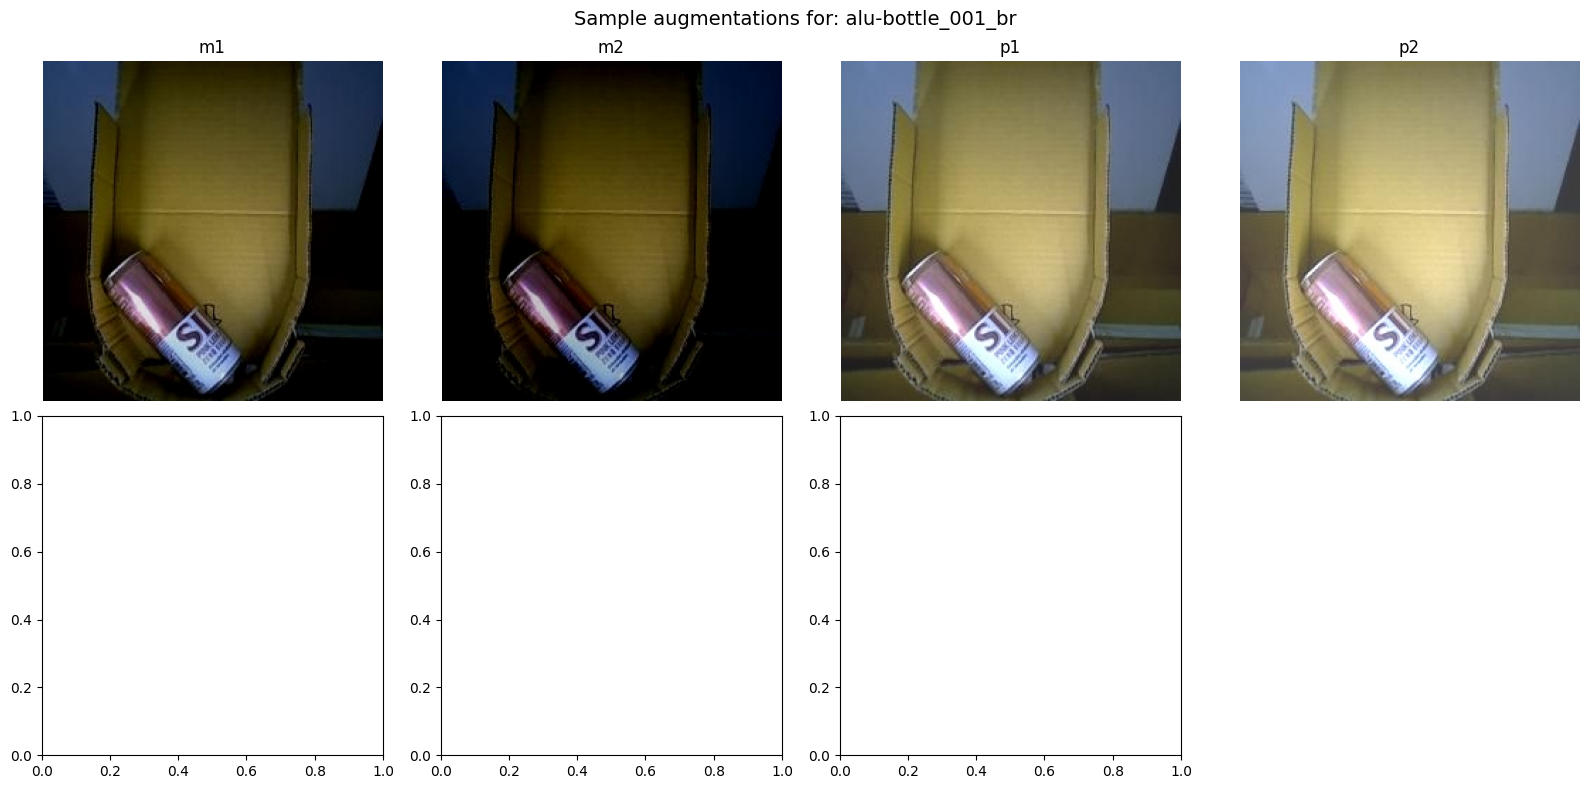

In [15]:
# Optional: Display sample augmentations (requires matplotlib)
try:
    import matplotlib.pyplot as plt

    # Get a sample image
    sample_folder = None
    for folder in AUGMENTED_DIR.iterdir():
        if folder.is_dir() and list(folder.iterdir()):
            sample_folder = folder
            break

    if sample_folder:
        # Get all variants of the first image
        files = sorted(sample_folder.iterdir())
        sample_base = (
            files[0].stem.rsplit("_", 1)[0] if "_" in files[0].stem else files[0].stem
        )

        variants = [f for f in files if f.stem.startswith(sample_base)]

        # Display
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()

        for i, variant in enumerate(variants[:7]):
            img = cv2.imread(str(variant))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(variant.stem.split("_")[-1])
            axes[i].axis("off")

        # Hide unused subplot
        axes[7].axis("off")

        plt.suptitle(f"Sample augmentations for: {sample_base}", fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print("No augmented images found to display.")

except ImportError:
    print("matplotlib not installed. Skipping visual verification.")
    print("Install with: pip install matplotlib")